In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

varieties_realease = pd.read_csv('Variedades.csv')
select_col_vr= ['Accession number', 'Continent', 'Country', 'Accession name',
       'Year of cross ', 'Year of release','Corporative Data Base (Clon) ', 'Corporative Data Base(Fam) ',
       'Invitro', 'Population', 'Catalogue', 'Organization']
varieties_realease = varieties_realease[select_col_vr]

exito = {}
for country in varieties_realease['Country'].unique():
    successful_varieties = varieties_realease[varieties_realease['Country'] == country]['Accession number'].tolist()
    cleaned_varieties = ['CIP ' + code.split('CIP')[1].strip() if 'CIP' in code else code for code in successful_varieties]
    # Asignar la lista limpia al diccionario de éxito
    exito[country] = cleaned_varieties


send_clones_historical = pd.read_csv("by_accesion.csv")
select_col_sch = ['Request Number', 'Crop', 'Consignee Country','Accession number', 'Date of Distribution', 'Quantity',
       'Form Material', 'Institution', 'Category of Institution','Distribution to the User', 'Purpose', 'Biological Status',
       'Biological Status CIP']
send_clones_historical_filter =  send_clones_historical[select_col_sch]
send_clones_historical_filter[['CIP', 'Family', 'Clone']] = send_clones_historical_filter['Accession number'].str.extract(r' ?(CIP) ?(\d+)(?:\.(\d+))?')
df = send_clones_historical_filter

df['Exito'] = df.apply(lambda row: row['Accession number'] in exito.get(row['Consignee Country'], []), axis=1)

columns = [
    'Quantity',
    'Form Material',
    'Category of Institution',
    'Distribution to the User',
    'Purpose',
    'Biological Status',
    'Biological Status CIP'
]

def calcular_score(row):
    score = 0
    if row['Exito']:
        score += 10
    score += row['Quantity'] / 100
    
    if row['Form Material'] == 'seed':
        score += 2
    else:
        score += 1
        
    if row['Purpose'] == 'Commercial Sector':
        score += 5
    elif row['Purpose'] == 'Agriculture':
        score += 4
    elif row['Purpose'] == 'Breeding':
        score += 3
    else:
        score += 1

    return score

df['Score'] = df.apply(calcular_score, axis=1)
score_table = df.pivot_table(index='Family', columns='Consignee Country', values='Score', aggfunc='mean', fill_value=0)

/tmp/ipykernel_5952/2666209325.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  send_clones_historical_filter[['CIP', 'Family', 'Clone']] = send_clones_historical_filter['Accession number'].str.extract(r' ?(CIP) ?(\d+)(?:\.(\d+))?')
/tmp/ipykernel_5952/2666209325.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  send_clones_historical_filter[['CIP', 'Family', 'Clone']] = send_clones_historical_filter['Accession number'].str.extract(r' ?(CIP) ?(\d+)(?:\.(\d+))?')
/tmp/ipykernel_5952/2666209325.py:20: 

In [5]:
varieties_realease.to_csv('varieties.csv', index=False)

In [46]:
import numpy as np
import pandas as pd

index_names = score_table.index  # Nombres de filas
column_names = score_table.columns  # Nombres de columnas

# Manejo de valores faltantes (rellenar con la media)
df_filled = score_table.fillna(score_table.mean())

matrix = df_filled.values.astype(float)
mean = np.mean(matrix, axis=0)
std_dev = np.std(matrix, axis=0)
R_normalized = (matrix - mean) / std_dev

# Aplicar SVD
try:
    U, sigma, VT = np.linalg.svd(R_normalized, full_matrices=False)
    print("SVD exitoso!")

    # Convertir sigma a una matriz diagonal
    sigma_matrix = np.diag(sigma)

    # Reconstruir aproximadamente la matriz original
    reconstructed_matrix = U @ sigma_matrix @ VT

    # Reconstruir DataFrame original aproximadamente
    reconstructed_df = pd.DataFrame(reconstructed_matrix, index=index_names, columns=column_names)

    print("\nDataFrame reconstruido:")
    print(reconstructed_df)

except np.linalg.LinAlgError as e:
    print("Error en SVD:", e)
except np.linalg.LinAlgError as e:
    print("Error en SVD:", e)


SVD exitoso!

DataFrame reconstruido:
Consignee Country  Afghanistan   Algeria    Angola  Argentina   Armenia  \
Family                                                                    
278072               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
278096               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
279023               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
280054               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
280090               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
...                        ...       ...       ...        ...       ...   
814002               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
814003               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
814004               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
819001               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
819002               -0.107754 -0.097023 -0.079555   -0.27793 

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
item_similarity = cosine_similarity(reconstructed_df.T)

def get_recommendations(column_name, item_similarity, reconstructed_df, top_n=5):
    column_idx = reconstructed_df.columns.get_loc(column_name)
    
    column_similarities = item_similarity[column_idx]
    
    similar_indices = column_similarities.argsort()[::-1][1:top_n+1]
    
    recommended_rows = reconstructed_df.index[similar_indices]
    return recommended_rows

item_name = 'Peru'
recommended_items = get_recommendations(item_name, item_similarity, reconstructed_df)
print(f"Recomendaciones para {item_name}: {recommended_items}")

Recomendaciones para Peru: Index(['302086', '300063', '300046', '285411', '302300'], dtype='object', name='Family')


In [48]:
column_idx = reconstructed_df.columns.get_loc('United States')
column_idx

106

In [49]:
column_similarities = item_similarity[column_idx]
column_similarities

array([-1.13858582e-02,  3.83974769e-02,  1.08249399e-01,  2.17726969e-01,
        2.19886693e-02,  2.56944414e-02,  5.50293329e-02, -1.93343520e-02,
        5.07064729e-02,  2.31606550e-02, -1.47282266e-02,  1.36371316e-02,
        5.31745415e-02,  2.38070490e-01, -1.83108297e-03,  1.39483967e-01,
        4.53204500e-02,  7.73554535e-02,  6.66364292e-02, -1.13608680e-02,
        1.04975203e-01, -2.85314318e-02,  3.98986655e-02,  2.00675088e-01,
        1.45910606e-01,  1.88597082e-01,  7.52713898e-02,  1.82189619e-01,
        7.19488232e-02,  3.16827615e-01,  1.95414219e-01, -1.55453516e-02,
        1.27647849e-02,  5.77754556e-02,  1.88180789e-02,  2.62631153e-01,
        2.41776263e-02,  3.47879874e-02,  1.20067100e-01, -4.86380189e-03,
       -1.57750711e-02,  1.06540239e-01,  1.42733645e-01, -1.11466434e-02,
        2.76871129e-03, -1.32070498e-03,  2.41819087e-02,  7.96450230e-02,
        1.71553676e-01,  2.28049983e-01, -9.53922166e-04,  1.92610064e-01,
        4.00151511e-02, -

In [50]:
similar_indices = column_similarities.argsort()[::-1][1:5+1]
similar_indices

array([29, 35, 13, 49, 59])

In [51]:
recommended_rows = reconstructed_df.index[similar_indices]
recommended_rows

Index(['288801', '300055', '285424', '301023', '301056'], dtype='object', name='Family')

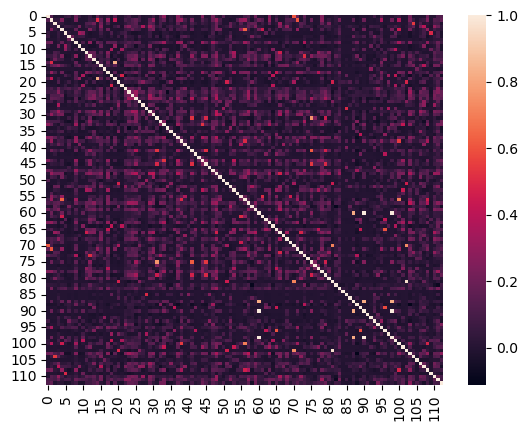

In [52]:
sns.heatmap(item_similarity)
plt.show()

In [77]:
recommended_items = get_recommendations('Canada', item_similarity, reconstructed_df, 5)
recommended_items

Index([301041, 288801, 288805, 288814, 300046], dtype='int64', name='Family')

In [80]:
recommended_items = get_recommendations('Canada', item_similarity, reconstructed_df, 5)
recommended_items

Index([301041, 288801, 288805, 288814, 300046], dtype='int64', name='Family')

In [144]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_values = pd.DataFrame(scaler.fit_transform(reconstructed_df), columns=reconstructed_df.columns)*5
#scaled_values['Family'] = reconstructed_df.index
scaled_values.index = reconstructed_df.index

In [145]:
scaled_values

,Afghanistan,Algeria,Angola,Argentina,Armenia,Australia,Austria,Bahamas,Bangladesh,Belarus,...,Turkey,Uganda,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Zimbabwe
Family,,,,,,,,,,,,,,,,,,,,,
278072,7.658804e-15,2.550044e-15,1.678345e-15,0.000000e+00,7.866971e-15,2.454634e-14,3.740741e+00,5.000000e+00,5.967449e-15,2.105954e-14,...,5.988265e-14,1.249435e-14,7.190429e-14,2.404327e-14,6.036838e-15,0.000000e+00,2.582136e-14,2.020000e+00,4.149459e-14,3.344371e+00
278096,5.585810e-15,1.047773e-14,1.181780e-15,1.221245e-14,2.975918e-14,1.399054e-14,3.740741e+00,0.000000e+00,6.314393e-15,1.366962e-14,...,6.376843e-14,9.137656e-15,7.277599e-14,1.981054e-14,1.006140e-15,3.361894e-14,2.402158e-14,3.733125e-14,3.941292e-14,0.000000e+00
279023,3.885781e-15,9.809861e-15,2.235625e-15,1.307982e-14,1.817123e-14,9.133319e-15,1.691355e-14,8.864437e-15,6.210310e-15,1.281961e-14,...,2.393918e-14,2.488027e-14,4.208333e+00,3.049644e-14,1.460637e-14,2.338407e-14,2.392184e-14,2.995867e-14,5.467848e-14,5.000000e+00
280054,6.487866e-15,1.096345e-14,1.086371e-15,1.276756e-14,8.708312e-15,2.246467e-14,2.289835e-14,1.047339e-14,1.214306e-16,6.277964e-14,...,2.331468e-14,1.316655e-14,4.208333e+00,5.669076e-14,4.010681e-14,3.441691e-14,2.323662e-14,4.649059e-15,5.329071e-14,7.979728e-15
280090,4.631712e-15,9.471590e-15,3.608225e-15,1.082467e-14,9.506285e-15,1.054712e-14,2.123302e-14,8.344020e-15,1.759010e-14,1.281961e-14,...,6.564194e-14,1.206066e-14,7.313160e-14,2.020000e+00,3.684553e-14,3.736594e-14,2.425143e-14,1.356554e-14,5.433154e-14,2.144118e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814002,4.891920e-15,8.847090e-15,2.426444e-15,1.356554e-14,8.578208e-15,1.017415e-14,2.331468e-14,8.508819e-15,5.689893e-15,9.540979e-15,...,2.643719e-14,1.224281e-14,7.437193e-14,2.380041e-14,1.817990e-14,2.185752e-14,2.411699e-14,1.644518e-14,5.148659e-14,1.856154e-14
814003,4.839878e-15,8.890458e-15,2.634611e-15,1.231654e-14,9.332812e-15,1.049508e-14,2.338407e-14,8.539176e-15,5.689893e-15,1.039099e-14,...,2.539635e-14,1.218643e-14,7.417244e-14,2.345346e-14,1.817990e-14,2.175343e-14,2.392184e-14,1.696560e-14,5.148659e-14,1.849215e-14
814004,4.891920e-15,8.560860e-15,2.521854e-15,1.318390e-14,8.838416e-15,1.027824e-14,2.331468e-14,8.413409e-15,5.290907e-15,9.315465e-15,...,2.678413e-14,1.216475e-14,7.441096e-14,2.386980e-14,1.804112e-14,2.213507e-14,2.411699e-14,1.679212e-14,5.141720e-14,1.866562e-14


In [146]:
import pandas as pd
import numpy as np

# Supongamos que 'data' es tu matriz original
# Crear una lista de índices (familias)
family = scaled_values.index.tolist()

# Crear una lista de valores de la matriz
values = scaled_values.values.flatten().tolist()

# Crear una lista de países basada en las columnas de la matriz original
countries = scaled_values.columns.tolist()

# Crear listas repetidas para alinear correctamente los datos
family_repeated = []
values_repeated = []
countries_repeated = []

for idx, fam in enumerate(family):
    for col_idx, country in enumerate(countries):
        family_repeated.append(fam)
        values_repeated.append(values[idx * len(countries) + col_idx])
        countries_repeated.append(country)

# Crear el DataFrame final
df = pd.DataFrame({
    'Family': family_repeated,
    'Value': values_repeated,
    'Country': countries_repeated
})

# Mostrar las primeras filas del DataFrame para verificar
print(df.head())

   Family         Value      Country
0  278072  7.658804e-15  Afghanistan
1  278072  2.550044e-15      Algeria
2  278072  1.678345e-15       Angola
3  278072  0.000000e+00    Argentina
4  278072  7.866971e-15      Armenia


In [143]:
tmp = df[df['Value'] >= 5]

In [148]:
df.to_csv('df_sql.csv', index=False)

In [149]:
df.shape

(157522, 3)

In [113]:
df_reestructurado = pd.melt(df, id_vars=['Family'], var_name='country_code', value_name='valor')

,Afghanistan,Algeria,Angola,Argentina,Armenia,Australia,Austria,Bahamas,Bangladesh,Belarus,...,Turkey,Uganda,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Zimbabwe
Family,,,,,,,,,,,,,,,,,,,,,
278072,7.658804e-15,2.550044e-15,1.678345e-15,0.000000e+00,7.866971e-15,2.454634e-14,3.740741e+00,5.000000e+00,5.967449e-15,2.105954e-14,...,5.988265e-14,1.249435e-14,7.190429e-14,2.404327e-14,6.036838e-15,0.000000e+00,2.582136e-14,2.020000e+00,4.149459e-14,3.344371e+00
278096,5.585810e-15,1.047773e-14,1.181780e-15,1.221245e-14,2.975918e-14,1.399054e-14,3.740741e+00,0.000000e+00,6.314393e-15,1.366962e-14,...,6.376843e-14,9.137656e-15,7.277599e-14,1.981054e-14,1.006140e-15,3.361894e-14,2.402158e-14,3.733125e-14,3.941292e-14,0.000000e+00
279023,3.885781e-15,9.809861e-15,2.235625e-15,1.307982e-14,1.817123e-14,9.133319e-15,1.691355e-14,8.864437e-15,6.210310e-15,1.281961e-14,...,2.393918e-14,2.488027e-14,4.208333e+00,3.049644e-14,1.460637e-14,2.338407e-14,2.392184e-14,2.995867e-14,5.467848e-14,5.000000e+00
280054,6.487866e-15,1.096345e-14,1.086371e-15,1.276756e-14,8.708312e-15,2.246467e-14,2.289835e-14,1.047339e-14,1.214306e-16,6.277964e-14,...,2.331468e-14,1.316655e-14,4.208333e+00,5.669076e-14,4.010681e-14,3.441691e-14,2.323662e-14,4.649059e-15,5.329071e-14,7.979728e-15
280090,4.631712e-15,9.471590e-15,3.608225e-15,1.082467e-14,9.506285e-15,1.054712e-14,2.123302e-14,8.344020e-15,1.759010e-14,1.281961e-14,...,6.564194e-14,1.206066e-14,7.313160e-14,2.020000e+00,3.684553e-14,3.736594e-14,2.425143e-14,1.356554e-14,5.433154e-14,2.144118e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814002,4.891920e-15,8.847090e-15,2.426444e-15,1.356554e-14,8.578208e-15,1.017415e-14,2.331468e-14,8.508819e-15,5.689893e-15,9.540979e-15,...,2.643719e-14,1.224281e-14,7.437193e-14,2.380041e-14,1.817990e-14,2.185752e-14,2.411699e-14,1.644518e-14,5.148659e-14,1.856154e-14
814003,4.839878e-15,8.890458e-15,2.634611e-15,1.231654e-14,9.332812e-15,1.049508e-14,2.338407e-14,8.539176e-15,5.689893e-15,1.039099e-14,...,2.539635e-14,1.218643e-14,7.417244e-14,2.345346e-14,1.817990e-14,2.175343e-14,2.392184e-14,1.696560e-14,5.148659e-14,1.849215e-14
814004,4.891920e-15,8.560860e-15,2.521854e-15,1.318390e-14,8.838416e-15,1.027824e-14,2.331468e-14,8.413409e-15,5.290907e-15,9.315465e-15,...,2.678413e-14,1.216475e-14,7.441096e-14,2.386980e-14,1.804112e-14,2.213507e-14,2.411699e-14,1.679212e-14,5.141720e-14,1.866562e-14


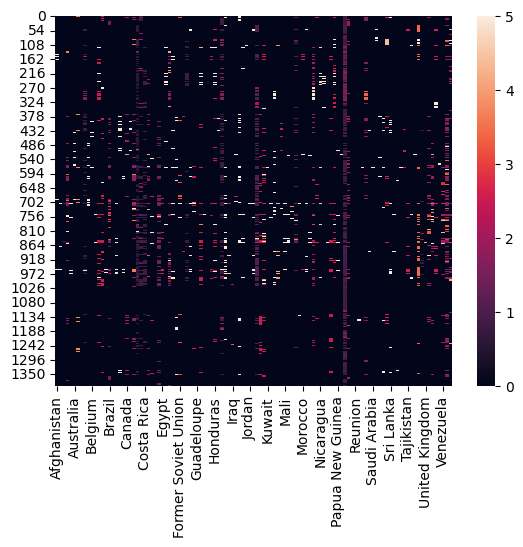

In [86]:
sns.heatmap(df_scaled)
plt.show()

In [101]:
reconstructed_df

,Afghanistan,Algeria,Angola,Argentina,Armenia,Australia,Austria,Bahamas,Bangladesh,Belarus,...,Turkey,Uganda,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Zimbabwe
Family,,,,,,,,,,,,,,,,,,,,,
278072,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,5.911040,15.209646,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,-0.294069,-0.244463,-0.23127,-0.065748,3.344401,-0.575675,4.196395
278096,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,5.911040,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232
279023,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,10.482951,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,6.398191
280054,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,10.482951,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232
280090,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,2.685340,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814002,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232
814003,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232
814004,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232


In [59]:
reconstructed_df.to_csv('reconstructed_df.csv', index=True)

In [63]:
np.savetxt('item_similarity.csv', item_similarity, delimiter=',', fmt='%d')

In [67]:
reconstructed_df = pd.read_csv('reconstructed_df.csv')
reconstructed_df.set_index('Family', inplace=True)

In [79]:
reconstructed_df

,Afghanistan,Algeria,Angola,Argentina,Armenia,Australia,Austria,Bahamas,Bangladesh,Belarus,...,Turkey,Uganda,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Zimbabwe
Family,,,,,,,,,,,,,,,,,,,,,
278072,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,5.911040,15.209646,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,-0.294069,-0.244463,-0.23127,-0.065748,3.344401,-0.575675,4.196395
278096,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,5.911040,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232
279023,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,10.482951,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,6.398191
280054,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,10.482951,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232
280090,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,2.685340,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814002,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232
814003,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232
814004,-0.107754,-0.097023,-0.079555,-0.27793,-0.089184,-0.111111,-0.167158,-0.065748,-0.293647,-0.114374,...,-0.407018,-0.141611,-0.093070,-0.294069,-0.244463,-0.23127,-0.065748,-0.214905,-0.575675,-0.251232


In [73]:
item_similarity = np.loadtxt('item_similarity.csv', delimiter=',', skiprows=1)

In [75]:
item_similarity

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
item_similarity

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import mysql.connector

def load_data_from_mysql():
    # Configurar la conexión a MySQL
    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="123a456",
        database="foreslab_catalogue"
    )

    # Consultar datos desde MySQL
    query = "SELECT * FROM `recommendations`"
    cursor = mydb.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()

   

    return rows

In [19]:
tmp = load_data_from_mysql()

In [20]:
df = pd.DataFrame(tmp, columns=['id', 'Family', 'valor', 'Country','time1','time2'])

In [23]:
df_reestructurado = pd.pivot_table(df, values='valor', index='Family', columns='Country', aggfunc='first')

In [24]:
df_reestructurado

Country,Afghanistan,Algeria,Angola,Argentina,Armenia,Australia,Austria,Bahamas,Bangladesh,Belarus,...,Turkey,Uganda,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Zimbabwe
Family,,,,,,,,,,,,,,,,,,,,,
278072,7.66E-15,2.55E-15,1.68E-15,0,7.87E-15,2.45E-14,3.740740741,5,5.97E-15,2.11E-14,...,5.99E-14,1.25E-14,7.19E-14,2.40E-14,6.04E-15,0,2.58E-14,2.02,4.15E-14,3.344370861
278096,5.59E-15,1.05E-14,1.18E-15,1.22E-14,2.98E-14,1.40E-14,3.740740741,0,6.31E-15,1.37E-14,...,6.38E-14,9.14E-15,7.28E-14,1.98E-14,1.01E-15,3.36E-14,2.40E-14,3.73E-14,3.94E-14,0
279023,3.89E-15,9.81E-15,2.24E-15,1.31E-14,1.82E-14,9.13E-15,1.69E-14,8.86E-15,6.21E-15,1.28E-14,...,2.39E-14,2.49E-14,4.208333333,3.05E-14,1.46E-14,2.34E-14,2.39E-14,3.00E-14,5.47E-14,5
280054,6.49E-15,1.10E-14,1.09E-15,1.28E-14,8.71E-15,2.25E-14,2.29E-14,1.05E-14,1.21E-16,6.28E-14,...,2.33E-14,1.32E-14,4.208333333,5.67E-14,4.01E-14,3.44E-14,2.32E-14,4.65E-15,5.33E-14,7.98E-15
280090,4.63E-15,9.47E-15,3.61E-15,1.08E-14,9.51E-15,1.05E-14,2.12E-14,8.34E-15,1.76E-14,1.28E-14,...,6.56E-14,1.21E-14,7.31E-14,2.02,3.68E-14,3.74E-14,2.43E-14,1.36E-14,5.43E-14,2.14E-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814002,4.89E-15,8.85E-15,2.43E-15,1.36E-14,8.58E-15,1.02E-14,2.33E-14,8.51E-15,5.69E-15,9.54E-15,...,2.64E-14,1.22E-14,7.44E-14,2.38E-14,1.82E-14,2.19E-14,2.41E-14,1.64E-14,5.15E-14,1.86E-14
814003,4.84E-15,8.89E-15,2.63E-15,1.23E-14,9.33E-15,1.05E-14,2.34E-14,8.54E-15,5.69E-15,1.04E-14,...,2.54E-14,1.22E-14,7.42E-14,2.35E-14,1.82E-14,2.18E-14,2.39E-14,1.70E-14,5.15E-14,1.85E-14
814004,4.89E-15,8.56E-15,2.52E-15,1.32E-14,8.84E-15,1.03E-14,2.33E-14,8.41E-15,5.29E-15,9.32E-15,...,2.68E-14,1.22E-14,7.44E-14,2.39E-14,1.80E-14,2.21E-14,2.41E-14,1.68E-14,5.14E-14,1.87E-14


In [13]:
df

,id,Family,valor,Country,time1,time2
0,1,278072,7.66E-15,Afghanistan,None,None
1,2,278072,2.55E-15,Algeria,None,None
2,3,278072,1.68E-15,Angola,None,None
3,4,278072,0,Argentina,None,None
4,5,278072,7.87E-15,Armenia,None,None
...,...,...,...,...,...,...
28907,28908,309118,1.67E-14,Slovakia,None,None
28908,28909,309118,2.61E-14,South Africa,None,None
28909,28910,309118,2.48E-14,Spain,None,None
28910,28911,309118,7.96E-14,Sri Lanka,None,None


In [44]:
last_update_file = 'last_update.txt'
import os



def verify_token(token):
    if token in tokens:
        return tokens[token]
    return None
    
def save_last_update():
    # Guardar la fecha y hora actual como la última actualización
    with open(last_update_file, 'w') as file:
        file.write(datetime.now().isoformat())


def load_data_from_mysql():
    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="123a456",
        database="foreslab_catalogue"
    )

    query = "SELECT * FROM `recommendations`"
    cursor = mydb.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()

    df = pd.DataFrame(rows, columns=['id', 'Family', 'valor', 'Country','time1','time2'])
    df_reestructurado = pd.pivot_table(df, values='valor', index='Family', columns='Country', aggfunc='first')
    cursor.close()
    mydb.close()

    csv_path = 'reconstructed_df.csv'
    df_reestructurado.to_csv(csv_path, index=True)
    save_last_update()

    return df_reestructurado

def load_last_update():
    if os.path.exists(last_update_file):
        with open(last_update_file, 'r') as file:
            last_update_str = file.read().strip()
            return datetime.fromisoformat(last_update_str)
    return None

def should_update_data():
    last_update = load_last_update()
    if last_update is None:
        return True  # Si nunca se ha actualizado, se debe actualizar ahora
    return (datetime.now() - last_update) >= timedelta(days=7)

def get_recommendations(column_name, reconstructed_df, top_n=5):
    column_idx = reconstructed_df.columns.get_loc(column_name)
    item_similarity = cosine_similarity(reconstructed_df.T)
    column_similarities = item_similarity[column_idx]
    similar_indices = column_similarities.argsort()[::-1][1:top_n+1]
    recommended_rows = reconstructed_df.index[similar_indices]
    return recommended_rows
    
def recommend():
    data = request.json
    column_name = data['column_name']

    # Verificar si es necesario actualizar los datos
    if should_update_data():
        # Cargar datos desde MySQL y guardar en archivo CSV
        reconstructed_df = load_data_from_mysql()
    else:
        # Cargar datos desde el archivo CSV local
        csv_path = 'reconstructed_df.csv'
        reconstructed_df = pd.read_csv(csv_path)

    recommended_items = get_recommendations(column_name, reconstructed_df)

    return jsonify({
        "column_name": column_name,
        "recommended_items": recommended_items.tolist()
    })


In [52]:
csv_path = 'reconstructed_df.csv'
reconstructed_df = pd.read_csv(csv_path) 
reconstructed_df.set_index('Family', inplace=True)

In [53]:
get_recommendations('Peru',reconstructed_df)

Index([288787, 301045, 300137, 302086, 302476], dtype='int64', name='Family')

In [37]:
tmop  = load_data_from_mysql()

In [38]:
tmop

Country,Afghanistan,Algeria,Angola,Argentina,Armenia,Australia,Austria,Bahamas,Bangladesh,Belarus,...,Turkey,Uganda,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Zimbabwe
Family,,,,,,,,,,,,,,,,,,,,,
278072,7.66E-15,2.55E-15,1.68E-15,0,7.87E-15,2.45E-14,3.740740741,5,5.97E-15,2.11E-14,...,5.99E-14,1.25E-14,7.19E-14,2.40E-14,6.04E-15,0,2.58E-14,2.02,4.15E-14,3.344370861
278096,5.59E-15,1.05E-14,1.18E-15,1.22E-14,2.98E-14,1.40E-14,3.740740741,0,6.31E-15,1.37E-14,...,6.38E-14,9.14E-15,7.28E-14,1.98E-14,1.01E-15,3.36E-14,2.40E-14,3.73E-14,3.94E-14,0
279023,3.89E-15,9.81E-15,2.24E-15,1.31E-14,1.82E-14,9.13E-15,1.69E-14,8.86E-15,6.21E-15,1.28E-14,...,2.39E-14,2.49E-14,4.208333333,3.05E-14,1.46E-14,2.34E-14,2.39E-14,3.00E-14,5.47E-14,5
280054,6.49E-15,1.10E-14,1.09E-15,1.28E-14,8.71E-15,2.25E-14,2.29E-14,1.05E-14,1.21E-16,6.28E-14,...,2.33E-14,1.32E-14,4.208333333,5.67E-14,4.01E-14,3.44E-14,2.32E-14,4.65E-15,5.33E-14,7.98E-15
280090,4.63E-15,9.47E-15,3.61E-15,1.08E-14,9.51E-15,1.05E-14,2.12E-14,8.34E-15,1.76E-14,1.28E-14,...,6.56E-14,1.21E-14,7.31E-14,2.02,3.68E-14,3.74E-14,2.43E-14,1.36E-14,5.43E-14,2.14E-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814002,4.89E-15,8.85E-15,2.43E-15,1.36E-14,8.58E-15,1.02E-14,2.33E-14,8.51E-15,5.69E-15,9.54E-15,...,2.64E-14,1.22E-14,7.44E-14,2.38E-14,1.82E-14,2.19E-14,2.41E-14,1.64E-14,5.15E-14,1.86E-14
814003,4.84E-15,8.89E-15,2.63E-15,1.23E-14,9.33E-15,1.05E-14,2.34E-14,8.54E-15,5.69E-15,1.04E-14,...,2.54E-14,1.22E-14,7.42E-14,2.35E-14,1.82E-14,2.18E-14,2.39E-14,1.70E-14,5.15E-14,1.85E-14
814004,4.89E-15,8.56E-15,2.52E-15,1.32E-14,8.84E-15,1.03E-14,2.33E-14,8.41E-15,5.29E-15,9.32E-15,...,2.68E-14,1.22E-14,7.44E-14,2.39E-14,1.80E-14,2.21E-14,2.41E-14,1.68E-14,5.14E-14,1.87E-14


In [42]:
tmop.shape

(1394, 113)